# 4.1 事後比較

## インポート・設定

In [1]:
import dataclasses
import warnings
from numbers import Number

import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown
from scipy import signal, special, stats

sns.set_theme()
warnings.simplefilter("ignore")
SEED = 0

## 解答

In [2]:
@dataclasses.dataclass
class BinomData:
    """0,1のデータの調査結果"""

    n: int
    y: int


@dataclasses.dataclass
class BetaDist:
    """ベータ分布のパラメータを格納するクラス"""

    a: Number
    b: Number

    def sample(self, size) -> np.ndarray:
        return stats.beta.rvs(a=self.a, b=self.b, size=size, random_state=SEED)


def get_binomial_model_posterior(n, y, a_prior, b_prior):

    # 事後分布のパラメータ
    a_posterior = a_prior + y
    b_posterior = b_prior + n - y

    return BetaDist(a=a_posterior, b=b_posterior)

それぞれの地域の政策支持率の調査結果

$$
\begin{cases}
N_1 = 100 \\
Y_1 = 57
\end{cases}

\quad

\begin{cases}
N_2 = 50 \\
Y_2 = 30
\end{cases}
$$

In [3]:
# 第1の地域の調査結果
data_area1 = BinomData(n=100, y=57)

# 第2の地域の調査結果
data_area2 = BinomData(n=50, y=30)

print("Area1:", data_area1)
print("Area2:", data_area2)

Area1: BinomData(n=100, y=57)
Area2: BinomData(n=50, y=30)


事前分布を一様分布(=Beta(1, 1))として事後分布を求める

In [4]:
# 事後分布を求める
posterior_area1 = get_binomial_model_posterior(
    n=data_area1.n,
    y=data_area1.y,
    a_prior=1,
    b_prior=1,
)
posterior_area2 = get_binomial_model_posterior(
    n=data_area2.n,
    y=data_area2.y,
    a_prior=1,
    b_prior=1,
)
print("Posterior of theta1:", posterior_area1)
print("Posterior of theta2:", posterior_area2)

Posterior of theta1: BetaDist(a=58, b=44)
Posterior of theta2: BetaDist(a=31, b=21)


それぞれの事後分布から5000個の値をサンプリングする

In [5]:
# 事後分布からサンプリングする
size = 5000
df_sample = pd.DataFrame(
    {
        "theta1": posterior_area1.sample(size),
        "theta2": posterior_area2.sample(size),
    }
)
df_sample.describe()

,theta1,theta2
count,5000.000000,5000.000000
mean,0.567845,0.595809
std,0.048444,0.067086
min,0.386398,0.344217
25%,0.534982,0.550675
50%,0.568667,0.597495
75%,0.600791,0.642091
max,0.721266,0.794851


サンプリングした値の分布を可視化してみる

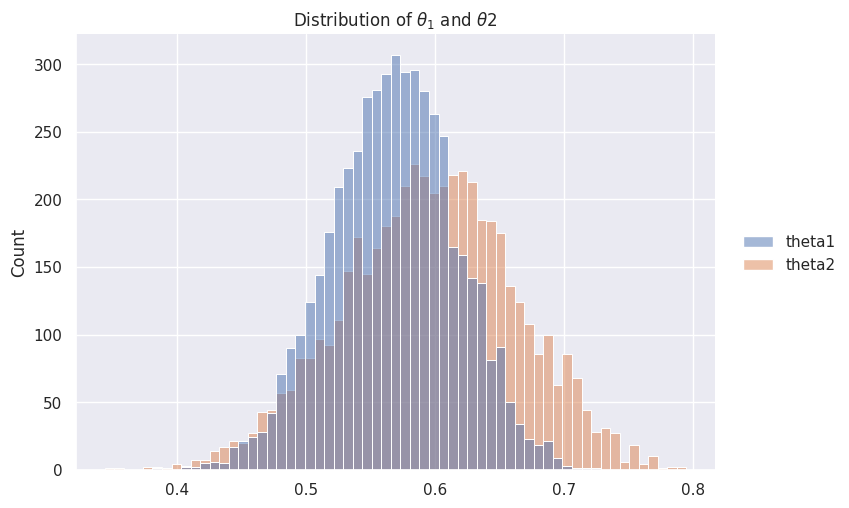

In [9]:
# 事後分布の可視化
g = sns.displot(
    df_sample,
    aspect=1.5,
)
_ = g.set(title=r"Distribution of $\theta_1$ and $\theta2$")

$\theta_2$ - $\theta_1$ の分布を可視化してみる

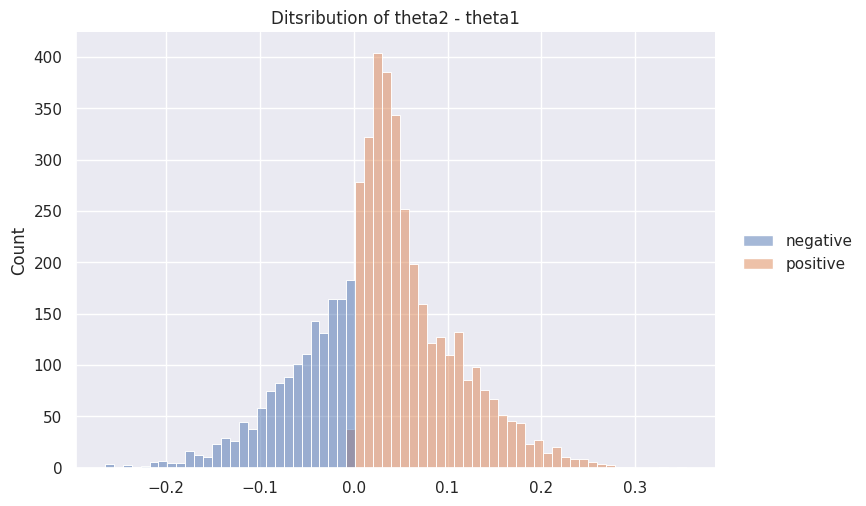

In [12]:
def plot_difference_of_variables(
    df: pd.DataFrame, var1: str, var2: str, title: str = None
):
    diff = df[var1].sub(df[var2]).values
    df_diff = pd.DataFrame()
    df_diff["negative"] = np.where(diff < 0, diff, np.nan)
    df_diff["positive"] = np.where(diff > 0, diff, np.nan)
    g = sns.displot(df_diff, aspect=1.5)
    title = title or f"Ditsribution of {var1} - {var2}"
    g.set(title=title)


plot_difference_of_variables(df_sample, "theta2", "theta1")

$Pr(\theta_1 < \theta_2 | データと事前分布)$ の推定値を算出する

In [13]:
# Pr(theta1 < theta2|データと事前分布)のモンテカルロ近似
proba = df_sample["theta1"].lt(df_sample["theta2"]).mean()
proba

0.6932